In [3]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

SCRIPTS_DIR = Path(".").resolve().parents[1]
sys.path.append(SCRIPTS_DIR.as_posix())
from path_fixer import allow_limap_imports, REPO_DIR

allow_limap_imports()

from limap_extension.optical_flow import OpticalFlow, RAFT_MODEL_PATH, Args
from limap_extension.transforms_spatial import get_transform_matrix_from_pose_array
from limap_extension.projection_based_flow import (projection_based_motion_segmentation,
                                                   reproject_img,
                                                   #project_img_pair_to_3d_using_flow,
                                                #    calculate_flow_field_and_reconstruct_imgs,
                                                #    segment_flow_field_basic
                                                )
from limap_extension.projection_based_flow import display_img_pair

%load_ext autoreload
%autoreload 2


In [6]:
# TRIAL_DIR = REPO_DIR / "datasets" / "ocean" / "Hard" / "P006"
TRIAL_DIR = REPO_DIR / "datasets" / "carwelding" / "easy" / "P007"

# Original testing frame
# FRAME_1 = 127
# FRAME_2 = 128

# This also looked good!
# FRAME_1 = 128
# FRAME_2 = 129

FRAME_1 = 129
FRAME_2 = 130

# Load in the data.
frame_str = f"{FRAME_1:06d}"
rgb_1 = np.array(Image.open(TRIAL_DIR / "image_left" / f"{frame_str}_left.png"))
depth_1 = np.load(TRIAL_DIR / "depth_left" / f"{frame_str}_left_depth.npy")

frame_str = f"{FRAME_2:06d}"
rgb_2 = np.array(Image.open(TRIAL_DIR / "image_left" / f"{frame_str}_left.png"))
depth_2 = np.load(TRIAL_DIR / "depth_left" / f"{frame_str}_left_depth.npy")

cam_poses = np.loadtxt(TRIAL_DIR / "pose_left.txt")

# Opting to crop the depth images before input to reprojection
# depth_max = 50
# depth_1 = np.clip(depth_1, None, depth_max)
# depth_2 = np.clip(depth_2, None, depth_max)

flow = OpticalFlow(None)
flow.load_model(RAFT_MODEL_PATH, Args())

cp1 = cam_poses[FRAME_1, :]
cp2 = cam_poses[FRAME_2, :]

pose_1 = get_transform_matrix_from_pose_array(cp1)
pose_2 = get_transform_matrix_from_pose_array(cp2)

Should we mask out the invalid projection motion?


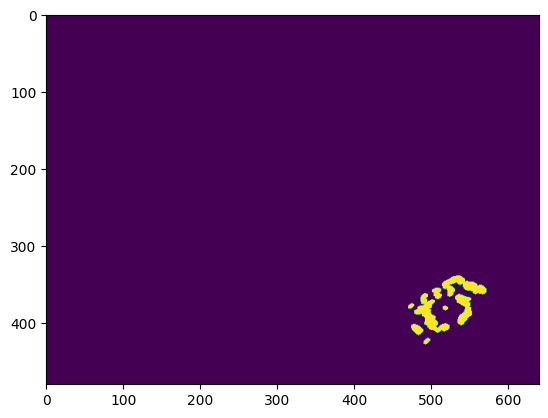

In [7]:
mask_test = projection_based_motion_segmentation(rgb_1, depth_1, rgb_2, depth_2, pose_1, pose_2,
                                                 flow)

plt.figure()
plt.imshow(mask_test)

In [ ]:
# Reproject the image at time t to the image frame at time t+1
img_1_in_frame_2, depth_1_in_frame_2, mask_valid_projection, valid_bbox = reproject_img(
    rgb_1, depth_1, pose_1, pose_2)

rgb_1_cropped = valid_bbox.crop_img(img_1_in_frame_2)
depth_1_cropped = valid_bbox.crop_img(depth_1_in_frame_2)
rgb_2_cropped = valid_bbox.crop_img(rgb_2)
depth_2_cropped = valid_bbox.crop_img(depth_2)
mask_valid_projection_cropped = valid_bbox.crop_img(mask_valid_projection)

img_height_cropped = rgb_1_cropped.shape[0]
img_width_cropped = rgb_1_cropped.shape[1]

# TODO: Make this a callable input to the function that either actually calculates the flow or
# loads in the ground truth flow?
# Might be easier to make this a flag and conditional.
_, flow_up = flow.infer_flow(rgb_1_cropped, rgb_2_cropped)
flow_up = flow_up[0].permute(1, 2, 0).cpu().numpy()

cloud_1, cloud_2 = project_img_pair_to_3d_using_flow(rgb_1_cropped, depth_1_cropped,
                                                     depth_2_cropped, rgb_2_cropped, flow_up,
                                                     mask_valid_projection_cropped)

flow_field, rgb_reconstructed, depth_reconstructed, mask_valid_reconstruction = \
    calculate_flow_field_and_reconstruct_imgs(
    cloud_1, cloud_2, img_height_cropped, img_width_cropped)

mask = segment_flow_field_basic(flow_field)

In [ ]:
# plt.figure()
# plt.imshow(depth_reconstructed)

ff_display = flow_field.copy()
ff_display = np.clip(ff_display, None, 10)
plt.figure()
plt.imshow(ff_display)
plt.colorbar()

plt.figure()
plt.imshow(mask)

plt.figure()
plt.imshow(mask_valid_reconstruction)

In [ ]:
depth_disparity = np.abs(depth_2_cropped - depth_reconstructed)
depth_disparity[~mask_valid_reconstruction] = -1

display_img_pair(depth_2_cropped, depth_reconstructed)

plt.figure()
plt.imshow(depth_disparity)
plt.title("Depth Disparity")
plt.colorbar()


def calculate_rgb_disparity(rgb_2_cropped, rgb_reconstructed, valid_reconstruction_mask):
    disparity = np.linalg.norm(rgb_2_cropped.astype(float) - rgb_reconstructed.astype(float),
                               axis=-1,
                               keepdims=True)
    disparity[~valid_reconstruction_mask] = -1
    return disparity


# rgb_disparity = np.linalg.norm(rgb_2_cropped.astype(float) - rgb_reconstructed.astype(float),
# axis=-1)
rgb_disparity = calculate_rgb_disparity(rgb_2_cropped, rgb_reconstructed, mask_valid_reconstruction)

display_img_pair(rgb_2_cropped, rgb_reconstructed)

plt.figure()
plt.imshow(rgb_disparity)
plt.title("RGB Disparity")
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(np.linalg.norm(flow_up, axis=-1))

plt.figure()
plt.imshow(flow_field)

In [ ]:
# Idea: decompose the flow field into planar and depth components.
from limap_extension.constants import CAM_INTRINSIC
from limap_extension.img_cloud_transforms import tform_coords, inverse_pose, get_uv_coords, uvz_ned_to_xyz_cam, xyz_cam_to_uvz_ned

us, vs = get_uv_coords(*flow_up.shape[:-1])
dus = flow_up[:, :, 1].flatten()
dvs = flow_up[:, :, 0].flatten()
zs_1_in_frame_2 = depth_1_cropped.reshape(-1)
# zs_2 = depth_2_cropped.reshape(-1)

xyz_1 = uvz_ned_to_xyz_cam(us, vs, zs_1_in_frame_2, CAM_INTRINSIC)
xyz_2 = uvz_ned_to_xyz_cam(us + dus, vs + dvs, zs_1_in_frame_2, CAM_INTRINSIC)

delta_xy = (xyz_1 - xyz_2)[:, :-1]
planar_motion = delta_xy.reshape(*flow_up.shape)

print("Should we mask out the invalid projection motion?")

# delta_uvs = flow_up.reshape(-1, 2)

# zs_1_in_frame_2 = depth_1_cropped.reshape(-1)

# planar_motion = zs_1_in_frame_2[:, None] * tform_coords(np.linalg.inv(CAM_INTRINSIC), delta_uvs)

# planar_motion = planar_motion.reshape(*flow_up.shape)


In [ ]:
x_ned_motion = planar_motion[:, :, 0]
y_ned_motion = planar_motion[:, :, 1]

plt.figure()
plt.imshow(x_ned_motion)

plt.figure()
plt.imshow(y_ned_motion)

flow_img_magnitude = np.linalg.norm(flow_up, axis=-1)
flow_planar_xy_magnitude = np.linalg.norm(planar_motion, axis=-1)
# plt.imshow()
display_img_pair(flow_img_magnitude, flow_planar_xy_magnitude)

In [ ]:
# Now, depth distance can be calculated by the difference in depth between the two frames.
depth_motion = np.abs(depth_2_cropped - depth_1_cropped)
depth_motion[valid_bbox.crop_img(~mask_valid_projection)] = 0.0

# For some reason, there's like two pixels that have HUGE depth disparity
depth_motion = np.clip(depth_motion, None, 3.0)

plt.figure()
plt.imshow(depth_motion)
plt.colorbar()

In [ ]:
planar_motion_masked = planar_motion.copy()
planar_motion_masked[valid_bbox.crop_img(~mask_valid_projection)] = 0.0
# full_motion = np.sqrt(np.linalg.norm(planar_motion_masked, axis=-1) + depth_motion)
# full_motion = np.zeros((*flow_up.shape[:-1], 3))
full_motion = np.concatenate((planar_motion, depth_motion[..., None]), axis=-1)

full_motion_mag = np.linalg.norm(full_motion, axis=-1)

plt.figure()
plt.imshow(full_motion_mag)

In [ ]:
dynamic_object_mask = full_motion_mag > 0.4
dynamic_object_mask[~proj_mask_to_use] = False

plt.figure(figsize=(10, 10))
plt.imshow(dynamic_object_mask)

In [ ]:
plt.figure()
plt.imshow(rgb_1_cropped)

plt.figure()
plt.imshow(rgb_2_cropped)

In [ ]:
import cv2

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

mask_valid_projection_cropped_dilated = cv2.morphologyEx(mask_valid_projection_cropped.astype(
    np.uint8),
                                                         cv2.MORPH_OPEN,
                                                         kernel,
                                                         iterations=5).astype(bool)

plt.figure()
plt.imshow(mask_valid_projection_cropped)

plt.figure()
plt.imshow(mask_valid_projection_cropped_dilated)

In [ ]:
from limap_extension.img_cloud_transforms import find_valid_uv_coords

# proj_mask_to_use = mask_valid_projection_cropped
proj_mask_to_use = mask_valid_projection_cropped_dilated

us, vs = get_uv_coords(*flow_up.shape[:-1])
dus = flow_up[:, :, 1].flatten()
dvs = flow_up[:, :, 0].flatten()
zs_1_in_frame_2 = depth_1_cropped.flatten()
zs_2 = depth_2_cropped.flatten()

img_height, img_width, _ = flow_up.shape

u_preds = np.round(us + dus).astype(int)
v_preds = np.round(vs + dvs).astype(int)
coords_valid = find_valid_uv_coords(u_preds, v_preds, img_height, img_width)
coords_valid = coords_valid & proj_mask_to_use.flatten()

us = us[coords_valid]
vs = vs[coords_valid]
u_preds = u_preds[coords_valid]
v_preds = v_preds[coords_valid]
zs_1_in_frame_2 = zs_1_in_frame_2[coords_valid]
zs_2 = zs_2[coords_valid]

xyz_1 = uvz_ned_to_xyz_cam(us, vs, zs_1_in_frame_2, CAM_INTRINSIC)
xyz_2 = uvz_ned_to_xyz_cam(u_preds, v_preds, zs_2, CAM_INTRINSIC)

delta_xyz = (xyz_2 - xyz_1)
# full_motion = delta_xy.reshape(*flow_up.shape[:-1], 3)
full_motion = np.zeros((img_height, img_width, 3))

# This is a mask for image 1. We should compute img 2 in frame 1 (reverse process) to get mask for
# image 2
us_reproj, vs_reproj, zs_reproj = xyz_cam_to_uvz_ned(xyz_1, is_rounding_to_int=True)
full_motion[vs_reproj, us_reproj] = delta_xyz


In [ ]:
full_motion_mag = np.linalg.norm(full_motion, axis=-1)
full_motion_mag = np.clip(full_motion_mag, None, 1.0)

plt.figure()
plt.imshow(full_motion_mag)

full_motion_mask = full_motion_mag > 0.4

plt.figure()
plt.imshow(full_motion_mask)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
full_motion_mask_adjusted = full_motion_mask.astype(np.uint8)
full_motion_mask_adjusted = cv2.erode(full_motion_mask_adjusted, kernel)
full_motion_mask_adjusted = cv2.morphologyEx(full_motion_mask_adjusted, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
full_motion_mask_adjusted = cv2.dilate(full_motion_mask_adjusted, kernel)

plt.figure()
plt.imshow(full_motion_mask_adjusted.astype(bool))